In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import glob
import os
from ripple_heterogeneity.utils import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels' #change to v7
functions.set_plotting_defaults()

## find data files

In [2]:

files = glob.glob(r"Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_analysis\**/*.csv",recursive=True)

dirnames = [os.path.dirname(file) for file in files]
dirnames = np.unique(dirnames)

## load data

In [3]:
df = pd.DataFrame()
for dirname in dirnames:
    layer_id = pd.read_csv(glob.glob(os.path.join(dirname,"*layerID.csv"))[0])

    red_cells_file = glob.glob(os.path.join(dirname,"*redcells.csv"))
    green_cells_file = glob.glob(os.path.join(dirname,"*greencells.csv"))
    colabel_cells_file = glob.glob(os.path.join(dirname,"*calb.csv"))

    if len(red_cells_file) > 0:
        df_temp = pd.read_csv(red_cells_file[0])
        df_temp["color"] = "red"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(green_cells_file) > 0:
        df_temp = pd.read_csv(green_cells_file[0])
        df_temp["color"] = "green"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    if len(calb) > 0:
        df_temp = pd.read_csv(calb[0])
        df_temp["color"] = "calb"
        df_temp["folder_name"] = dirname
        df = pd.concat([df,df_temp],ignore_index=True)

    df.loc[df.folder_name == dirname,"layer_rad_y"] = layer_id.Y.iloc[0]
    df.loc[df.folder_name == dirname,"layer_or_y"] = layer_id.Y.iloc[1]

df["normalized_dist"] = np.abs(df.Y - df.layer_rad_y) / abs(df.layer_rad_y - df.layer_or_y)
df

,,Area,Mean,Min,Max,X,Y,Ch,Slice,color,folder_name,layer_rad_y,layer_or_y,normalized_dist
0,1,0.0,2855,2855,2855,28.389,195.244,1,4,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,225.950,109.789,0.264340
1,2,0.0,4455,4455,4455,113.265,190.899,1,9,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,225.950,109.789,0.301745
2,3,0.0,2338,2338,2338,405.262,227.978,1,9,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,225.950,109.789,0.017459
3,4,0.0,13060,13060,13060,305.612,196.693,1,15,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,225.950,109.789,0.251866
4,5,0.0,6270,6270,6270,204.224,178.153,1,15,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,225.950,109.789,0.411472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,7,0.0,5311,5311,5311,223.343,183.367,1,16,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.389651
229,8,0.0,10976,10976,10976,125.431,210.018,1,3,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.138967
230,9,0.0,55238,55238,55238,103.995,220.446,1,3,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.040879
231,10,0.0,4636,4636,4636,216.970,149.764,1,7,red,Z:\home\Heath\Viral_tracing\CTB\CALB1\calb1_an...,224.792,118.479,0.705727


## plot smoothed distribution of distances per projection type

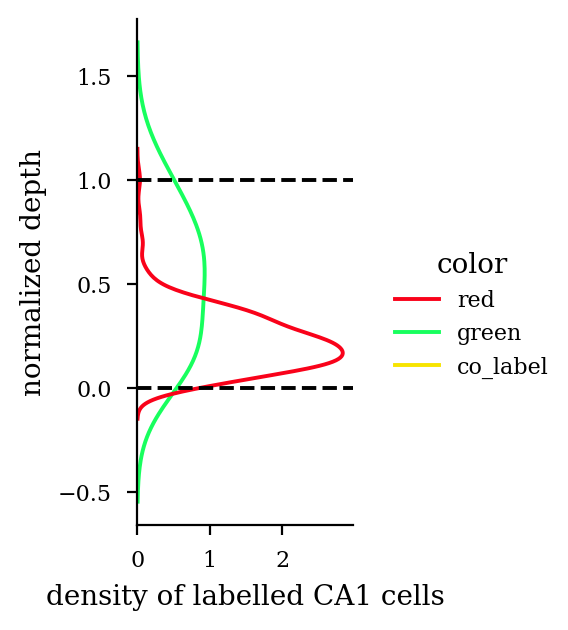

In [4]:
h,w = functions.set_size("thesis", fraction=.55, subplots=(1, 1))

group_colors = {"red": "#f9021a", "green": "#18ff5e","calb":"#f7e400"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.displot(df, y="normalized_dist", hue="color",hue_order=group_colors, kind="kde", fill=False,common_norm=False,height=h,aspect=w/h,alpha=1)
plt.axhline(0,color="k",linestyle="--")
plt.axhline(1,color="k",linestyle="--")
plt.xlabel("density of labelled CA1 cells")
plt.ylabel("normalized depth")

plt.savefig(os.path.join(fig_save_path,'normalized_depth_labelled_ca1_cells_calb.svg'),dpi=300,bbox_inches='tight')


## rank sum test between green and red distance

In [5]:
ranksums(df.query("color=='red'").normalized_dist,df.query("color=='green'").normalized_dist)

RanksumsResult(statistic=-2.5596081069118104, pvalue=0.010479025768807191)

## get proportions of cells 

In [6]:
prop_df = df.groupby("color").apply(lambda x: pd.Series({"n_cells":len(x)})).reset_index()
prop_df["prop"] = prop_df.n_cells / prop_df.n_cells.sum()
prop_df["constant"] = 1

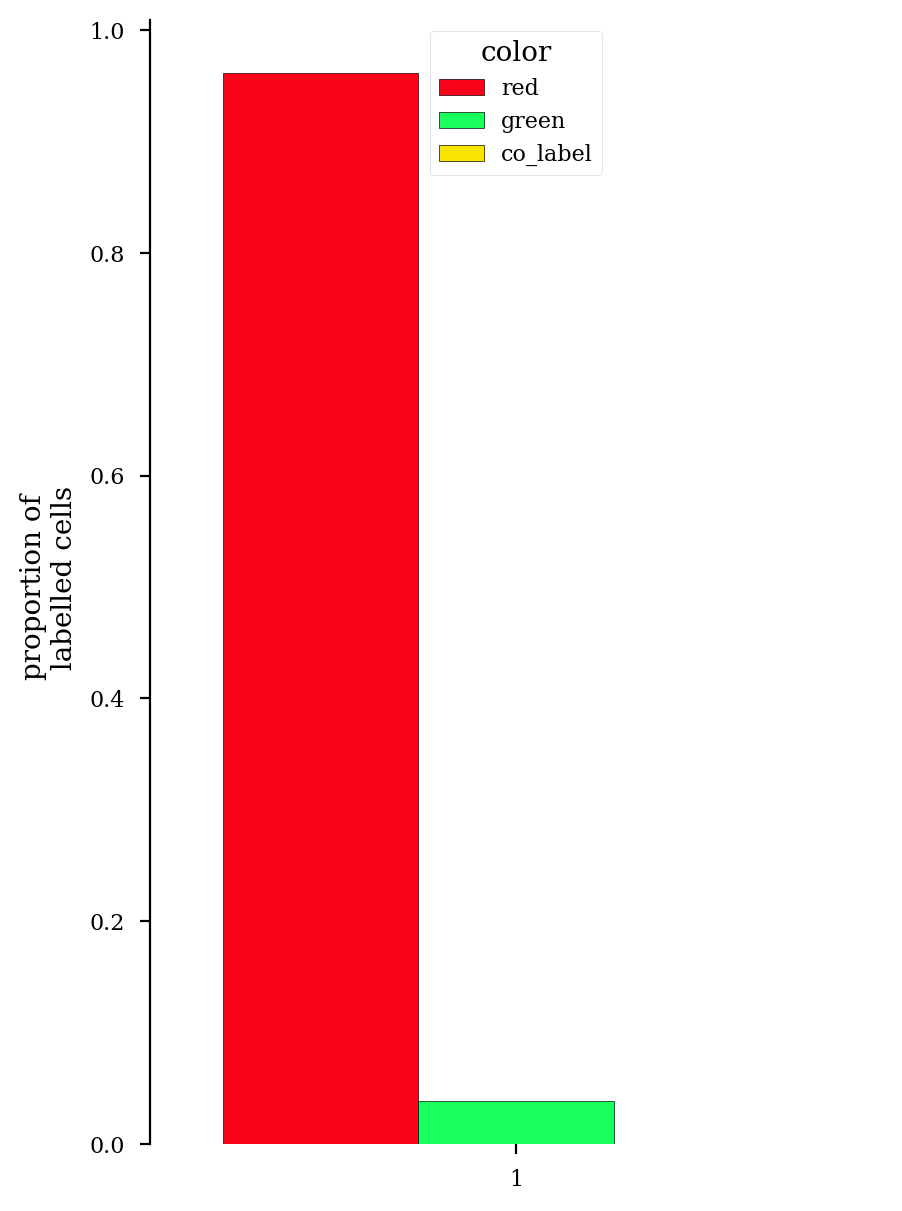

In [8]:
plt.figure(figsize = functions.set_size("thesis", fraction=.8, subplots=(2.5, 1)))

sns.barplot(data=prop_df,x="constant", hue="color", y="prop",hue_order=group_colors,edgecolor="k",saturation=1)
sns.despine(bottom=True)
plt.ylabel("proportion of \n labelled cells")
plt.xlabel("")
plt.savefig(os.path.join(fig_save_path,'prop_of_labelled_cells_calb.svg'),dpi=300,bbox_inches='tight')


## make distribution plot for each animal